In [7]:
import os
import re
from pathlib import Path
from bs4 import BeautifulSoup
import pandas as pd
from collections import defaultdict

In [8]:
# Set up paths
audit_dir = Path(r"d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Streamlit app\audit_records")
print(f"Audit directory: {audit_dir}")
print(f"Directory exists: {audit_dir.exists()}")

Audit directory: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Streamlit app\audit_records
Directory exists: True


# Custom AST Detection Methods Analysis

Analyzing unique CWE-IDs detected by custom AST methods from all summary reports in audit records

In [9]:
# Parse all summary reports from audit records and extract ALL vulnerabilities
def parse_all_vulnerabilities(html_file):
    """
    Parse a summary_report HTML file and extract ALL vulnerabilities with their detection methods.
    Also extracts the actual source file from the corresponding audit JSON file.
    
    Args:
        html_file: Path to summary_report*.html file
        
    Returns:
        List of dicts containing vulnerability info including CWE-ID, name, detection method, and source file
    """
    try:
        with open(html_file, 'r', encoding='utf-8') as f:
            soup = BeautifulSoup(f.read(), 'html.parser')
        
        # Extract workflow_id from the HTML filename
        workflow_id_match = re.search(r'summary_report_(\d{8}_\d{6})\.html', html_file.name)
        workflow_id = workflow_id_match.group(1) if workflow_id_match else 'unknown'
        
        # Try to find and read the corresponding audit JSON file to get the actual source file
        audit_json_path = html_file.parent / f'audit_{workflow_id}.json'
        actual_source_file = 'unknown'
        
        if audit_json_path.exists():
            try:
                import json
                with open(audit_json_path, 'r', encoding='utf-8') as audit_f:
                    audit_data = json.load(audit_f)
                    actual_source_file = audit_data.get('source_file', audit_data.get('file', 'unknown'))
            except Exception as e:
                print(f"  Warning: Could not read audit file {audit_json_path.name}: {e}")
        
        # Find the vulnerabilities table
        table = soup.find('table')
        if not table:
            return []
        
        rows = table.find_all('tr')[1:]  # Skip header row
        all_vulns = []
        
        for row in rows:
            cells = row.find_all('td')
            if len(cells) >= 6:
                cwe_id = cells[0].text.strip()
                cwe_name = cells[1].text.strip()
                severity = cells[2].text.strip()
                line = cells[3].text.strip()
                description = cells[4].text.strip()
                detection_method = cells[5].text.strip()
                
                all_vulns.append({
                    'cwe_id': cwe_id,
                    'cwe_name': cwe_name,
                    'severity': severity,
                    'line': line,
                    'description': description,
                    'detection_method': detection_method,
                    'workflow_id': workflow_id,
                    'source_file': actual_source_file,
                    'summary_report': html_file.name,
                    'audit_folder': html_file.parent.name
                })
        
        return all_vulns
    
    except Exception as e:
        print(f"Error parsing {html_file}: {e}")
        return []

# Traverse all audit folders and collect vulnerabilities from all summary reports
all_vulnerabilities = []
summary_files_found = 0

print(f"Scanning audit directory: {audit_dir}")
print(f"{'='*80}")

for audit_folder in audit_dir.iterdir():
    if audit_folder.is_dir():
        # Find all summary_report*.html files in each audit folder
        for html_file in audit_folder.glob('summary_report*.html'):
            summary_files_found += 1
            vulns = parse_all_vulnerabilities(html_file)
            all_vulnerabilities.extend(vulns)
            if vulns:
                print(f"Processed: {audit_folder.name}/{html_file.name}")
                print(f"  Source File: {vulns[0]['source_file']}")
                print(f"  Workflow ID: {vulns[0]['workflow_id']}")
                print(f"  Vulnerabilities: {len(vulns)}")

print(f"{'='*80}")
print(f"\nTotal summary report files found: {summary_files_found}")
print(f"Total vulnerabilities extracted: {len(all_vulnerabilities)}")

# Create DataFrame from all vulnerabilities
df_all_vulns = pd.DataFrame(all_vulnerabilities)

if not df_all_vulns.empty:
    print(f"\nAll detection methods found across all summary reports:")
    print(df_all_vulns['detection_method'].value_counts())
    print(f"\nUnique source files analyzed:")
    print(f"  Total: {df_all_vulns['source_file'].nunique()}")
    print(f"\nSource files:")
    for source_file in sorted(df_all_vulns['source_file'].unique()):
        count = len(df_all_vulns[df_all_vulns['source_file'] == source_file])
        print(f"  {source_file}: {count} vulnerabilities")
else:
    print("\nNo vulnerabilities found in summary reports.")

Scanning audit directory: d:\Vincy-Certificates\AIDA\Winter'25\Thesis\Prototype\Streamlit app\audit_records
Processed: 20251219_141453_CWE-020_author_1/summary_report_20251219_151500.html
  Source File: CWE-020/author_1.py
  Workflow ID: 20251219_151500
  Vulnerabilities: 2
Processed: 20251219_144521_CWE-022_author_1/summary_report_20251219_154533.html
  Source File: CWE-022/author_1.py
  Workflow ID: 20251219_154533
  Vulnerabilities: 3
Processed: 20251219_154441_CWE-080_author_1/summary_report_20251219_164453.html
  Source File: CWE-080/author_1.py
  Workflow ID: 20251219_164453
  Vulnerabilities: 6
Processed: 20251219_155008_CWE-094_author_1/summary_report_20251219_165024.html
  Source File: CWE-094/author_1.py
  Workflow ID: 20251219_165024
  Vulnerabilities: 5
Processed: 20251219_155134_CWE-095_author_1/summary_report_20251219_165140.html
  Source File: CWE-095/author_1.py
  Workflow ID: 20251219_165140
  Vulnerabilities: 4
Processed: 20251219_160137_CWE-259_author_2/summary_repor

In [10]:
# Prepare filtered dataset used for the detailed CWE-by-dataset figure
# (exclude external tools like bandit and semgrep)
custom_ast_methods = [
    'ast', 'ast-param', 'ast-framework', 'ast-taint', 'ast-except',
    'ast-config', 'ast-interprocedural', 'semantic-pattern', 'similarity+AST'
]

# Keep only detections from custom AST-based methods
df_custom = df_all_vulns[df_all_vulns['detection_method'].isin(custom_ast_methods)].copy()

print(f"Custom AST detections: {len(df_custom)} across {df_custom['detection_method'].nunique()} methods.")

Custom AST detections: 63 across 7 methods.


## Comprehensive CWE Analysis: Custom AST Detection by Dataset

Analyzing CWE occurrences across workflows and datasets (SecurityEval vs Manual)


COMPREHENSIVE CWE ANALYSIS BY DATASET
Total custom AST detections: 63

Dataset distribution:
dataset
Manual          32
SecurityEval    31
Name: count, dtype: int64


Generating detailed visual table with detection methods by dataset...


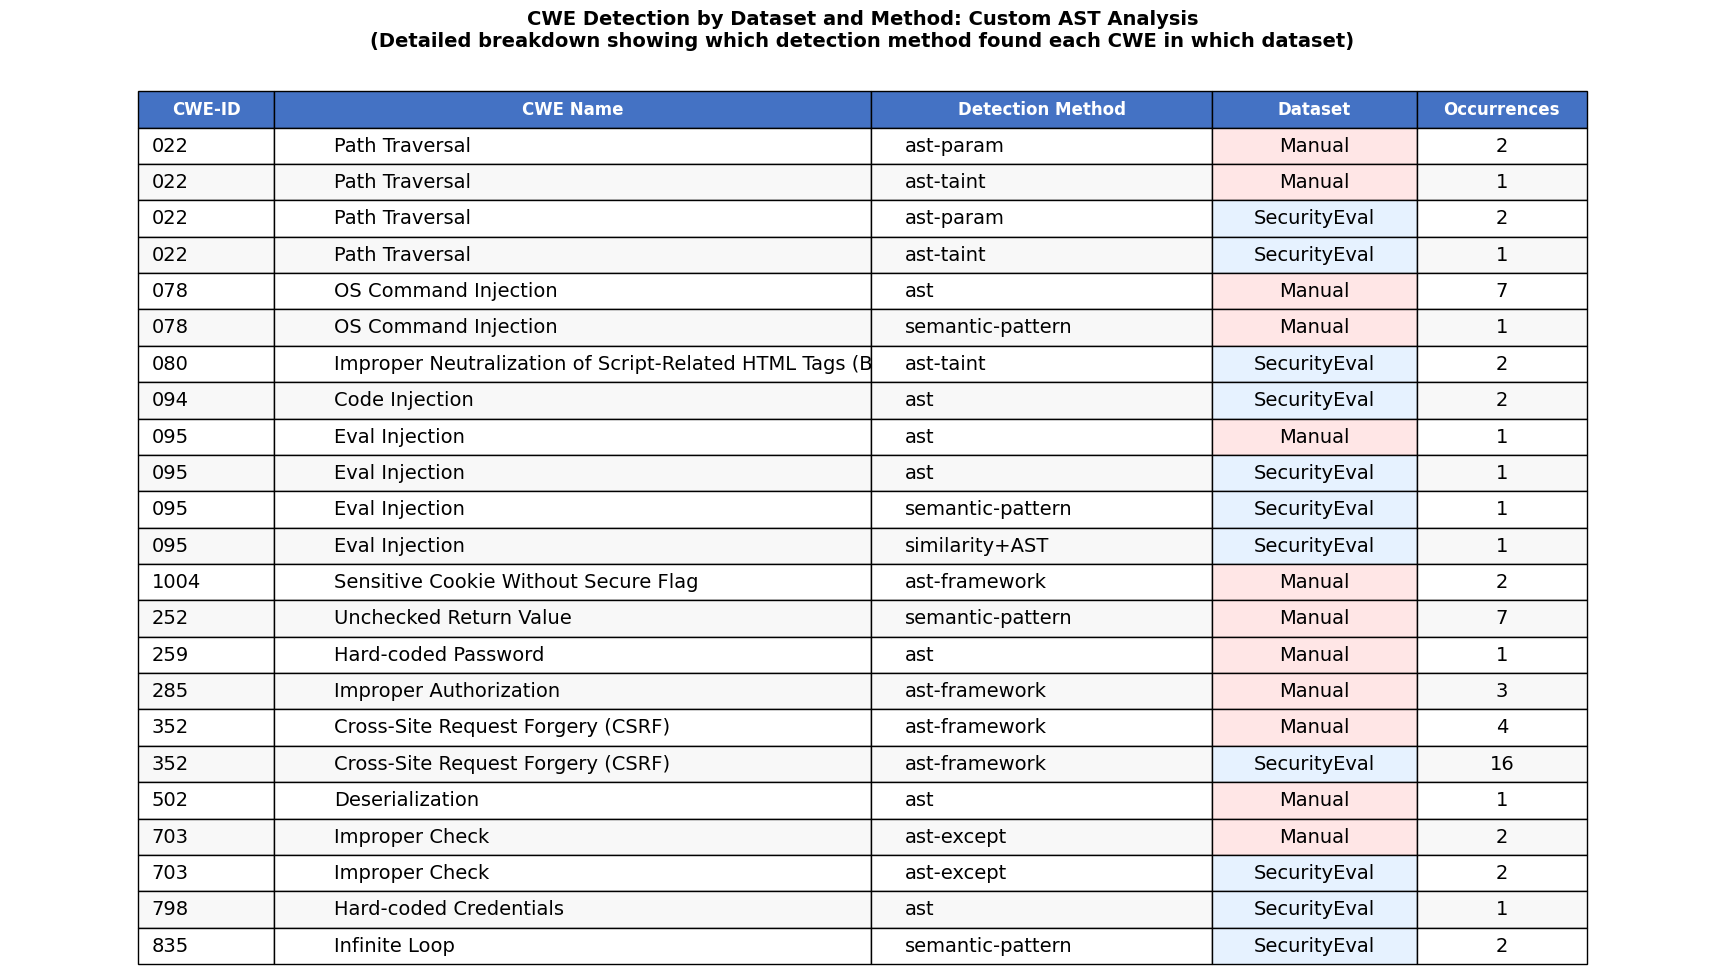


DETAILED ANALYSIS SUMMARY
Total rows in detailed breakdown: 23
Total unique CWEs: 14
Total unique detection methods: 7

Detection method distribution:
  ast-framework: 25 occurrences
  ast: 14 occurrences
  semantic-pattern: 11 occurrences
  ast-except: 4 occurrences
  ast-param: 4 occurrences
  ast-taint: 4 occurrences
  similarity+AST: 1 occurrences

Dataset distribution:
  Manual: 32 occurrences
  SecurityEval: 31 occurrences

Legend:
  - SecurityEval (light blue): CWEs from Author_Insecure_Code dataset
  - Manual (light red): CWEs from manually crafted prompts
  - Each row shows: Which detection method found which CWE in which dataset


In [11]:
import matplotlib.pyplot as plt

# Determine dataset type (SecurityEval or Manual) from audit folder names
def classify_dataset(audit_folder_name):
    """
    Classify the dataset based on audit folder name.
    - Manual: folders containing 'manual_prompt'
    - SecurityEval: folders with CWE patterns and author numbers
    """
    if 'manual_prompt' in audit_folder_name.lower():
        return 'Manual'
    else:
        return 'SecurityEval'

# Add dataset classification to df_custom
df_custom['dataset'] = df_custom['audit_folder'].apply(classify_dataset)

# Create comprehensive analysis
print(f"\n{'='*80}")
print(f"COMPREHENSIVE CWE ANALYSIS BY DATASET")
print(f"{'='*80}")
print(f"Total custom AST detections: {len(df_custom)}")
print(f"\nDataset distribution:")
print(df_custom['dataset'].value_counts())
print(f"{'='*80}\n")

# Group by CWE and dataset to count occurrences
cwe_dataset_analysis = df_custom.groupby(['cwe_id', 'cwe_name', 'dataset']).agg({
    'workflow_id': 'count',  # Count occurrences
    'source_file': lambda x: x.nunique()  # Count unique source files
}).reset_index()
cwe_dataset_analysis.columns = ['CWE-ID', 'CWE Name', 'Dataset', 'Occurrences', 'Unique Files']

# Pivot to show datasets side by side
cwe_pivot = cwe_dataset_analysis.pivot_table(
    index=['CWE-ID', 'CWE Name'],
    columns='Dataset',
    values='Occurrences',
    fill_value=0,
    aggfunc='sum'
).reset_index()

# Calculate total occurrences
dataset_columns = [col for col in cwe_pivot.columns if col in ['SecurityEval', 'Manual']]
cwe_pivot['Total Occurrences'] = cwe_pivot[dataset_columns].sum(axis=1)

# Add a column showing which datasets the CWE appeared in
def get_datasets(row):
    datasets = []
    if 'SecurityEval' in row.index and row['SecurityEval'] > 0:
        datasets.append('SecurityEval')
    if 'Manual' in row.index and row['Manual'] > 0:
        datasets.append('Manual')
    return ', '.join(datasets) if datasets else 'None'

cwe_pivot['Appears In'] = cwe_pivot.apply(get_datasets, axis=1)

# Sort by total occurrences
cwe_pivot = cwe_pivot.sort_values('Total Occurrences', ascending=False)

# Create detailed breakdown: CWE + Detection Method + Dataset
detailed_analysis = df_custom.groupby(['cwe_id', 'cwe_name', 'detection_method', 'dataset']).size().reset_index(name='occurrences')
detailed_analysis = detailed_analysis.sort_values(['cwe_id', 'dataset', 'detection_method'])

# Create visual table using matplotlib
print(f"\nGenerating detailed visual table with detection methods by dataset...")

# Prepare table data
table_data = []
headers = ['CWE-ID', 'CWE Name', 'Detection Method', 'Dataset', 'Occurrences']

for _, row in detailed_analysis.iterrows():
    cwe_id = row['cwe_id']
    cwe_name = row['cwe_name']
    detection_method = row['detection_method']
    dataset = row['dataset']
    occurrences = int(row['occurrences'])
    
    table_data.append([cwe_id, cwe_name, detection_method, dataset, occurrences])

# Create figure with appropriate size
num_rows = len(table_data)
fig_height = min(max(10, num_rows * 0.35), 25)
fig_width = 22

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.axis('tight')
ax.axis('off')

# Create the table with adjusted column widths
table = ax.table(cellText=table_data,
                colLabels=headers,
                cellLoc='left',
                loc='upper center',
                colWidths=[0.08, 0.35, 0.20, 0.12, 0.10])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.0)

# Header styling
for i in range(len(headers)):
    cell = table[(0, i)]
    cell.set_facecolor('#4472C4')
    cell.set_text_props(weight='bold', color='white', fontsize=12, ha='center')

# Data cells styling with alternating colors
for i in range(1, num_rows + 1):
    # Alternate row colors
    row_color = '#F8F8F8' if i % 2 == 0 else '#FFFFFF'
    
    for j in range(len(headers)):
        cell = table[(i, j)]
        cell.set_facecolor(row_color)
        cell.set_text_props(fontsize=14)
        
        # Center align Dataset and Occurrences columns
        if j in [3, 4]:  # Dataset, Occurrences columns
            cell.set_text_props(ha='center', fontsize=14)
        
        # Highlight dataset-specific rows
        if j == 3:  # Dataset column
            dataset_val = table_data[i-1][j]
            if dataset_val == 'SecurityEval':
                cell.set_facecolor('#E6F2FF')  # Light blue for SecurityEval
            elif dataset_val == 'Manual':
                cell.set_facecolor('#FFE6E6')  # Light red for Manual

plt.title('CWE Detection by Dataset and Method: Custom AST Analysis\n(Detailed breakdown showing which detection method found each CWE in which dataset)', 
          fontsize=14, fontweight='bold', pad=20)
plt.subplots_adjust(top=0.95)
plt.show()

# Print summary statistics
print(f"\n{'='*80}")
print(f"DETAILED ANALYSIS SUMMARY")
print(f"{'='*80}")
print(f"Total rows in detailed breakdown: {len(detailed_analysis)}")
print(f"Total unique CWEs: {detailed_analysis['cwe_id'].nunique()}")
print(f"Total unique detection methods: {detailed_analysis['detection_method'].nunique()}")
print(f"\nDetection method distribution:")
method_counts = detailed_analysis.groupby('detection_method')['occurrences'].sum().sort_values(ascending=False)
for method, count in method_counts.items():
    print(f"  {method}: {count} occurrences")
print(f"\nDataset distribution:")
dataset_counts = detailed_analysis.groupby('dataset')['occurrences'].sum()
for dataset, count in dataset_counts.items():
    print(f"  {dataset}: {count} occurrences")
print(f"\nLegend:")
print(f"  - SecurityEval (light blue): CWEs from Author_Insecure_Code dataset")
print(f"  - Manual (light red): CWEs from manually crafted prompts")
print(f"  - Each row shows: Which detection method found which CWE in which dataset")
print(f"{'='*80}")